In [1]:
import numpy as np

import netCDF4 as nc
from datetime import datetime, timedelta, time


import matplotlib.pyplot as plt

import pandas as pd
import os

from scipy import stats
import scipy as sp

import folium
from scipy.spatial import ConvexHull
from branca.element import Template, MacroElement


# Data formating



## Data collection

### Cabauw

#### First dataset for Cabauw 2000-2023 (netCDF)

we take the wind speed and direction in the data to create a full csv file with all the wind seed and direction over 23 years (2000-2023) and for differents heights.

In [90]:
file = nc.Dataset("CODE/Data_Cabauw/MEASURED//towerdata-download/cesar_tower_meteo_lb1_t10_v1.2_200007.nc")

print(file.variables)
# file.variables['PF'][:]

{'iso_dataset': <class 'netCDF4._netCDF4.Variable'>
|S1 iso_dataset()
    hierarchyLevel: dataset
    url: http://www.cesar-database.nl
    protocol: website
    topic: climatologyMeteorologyAtmosphere
    westbound_longitude: 4.926
    eastbound_longitude: 4.926
    southbound_latitude: 51.97
    northbound_latitude: 51.97
    datasetDateType: publication
    code: 28992
    codeSpace: EPSG
    accessConstraints: CESAR data policy
    useLimitation: None
    organisationName_dataset: Royal Netherlands Meteorological Institute (KNMI)
    email_dataset: fred.bosveld@knmi.nl
    role_dataset: Principle Investigator
    organisationName_metadata: Royal Netherlands Meteorological Institute (KNMI)
    role_metadata: Principle Investigator
    email_metadata: fred.bosveld@knmi.nl
    url_metadata: http://www.knmi.nl/~bosveld
    metadataDateType: creation
    language: eng
    metadataStandardName: ISO-19115
    metadataStandardNameVersion: Nederlands profiel op ISO 19115 voor geografie, v1.

In [3]:

data = pd.DataFrame()

dir = "./CODE/Data_Cabauw/MEASURED/towerdata-download/"


for file in os.listdir(dir):
    filepath = os.path.join(dir, file)
    # Check if it's a file
    if os.path.isfile(filepath):
        
        # Open the .nc file
        nc_file = nc.Dataset(filepath)



        # Extract time units string and convert it to datetime object
        time_units = nc_file.variables['time'].units
        off = datetime.strptime(time_units[12:31], "%Y-%m-%d %H:%M:%S")

        # Extract time values and convert to datetime objects
        time_vals = nc_file.variables['time'][:]
        T = [off + timedelta(minutes=round(60 * val)) for val in time_vals]

        data_ = pd.DataFrame({'DateTime':T})

        # heights
        Z = nc_file.variables['z'][:-1]
        valid_val = np.ones(len(Z) + 1,dtype=bool)
        valid_val[-1] = False
        if np.sum(Z.mask):
            valid_val[:-1] = ~Z.mask
            print(f"open '{filepath}'")
            print(f"Heights {Z[Z.mask]} not valid")
            Z = Z[~Z.mask]
            

        # wind speed
        F = nc_file.variables['F'][:,valid_val]
        F_col = [f"F{'{:03d}'.format(round(z))}" for z in Z]
        F = pd.DataFrame(F,columns=F_col)
        
        # max wind speed
        PF = nc_file.variables['PF'][:,valid_val]
        PF_col = [f"PF{'{:03d}'.format(round(z))}" for z in Z]
        PF = pd.DataFrame(PF,columns=PF_col)

        # wind direction
        D = nc_file.variables['D'][:,valid_val]
        D_col = [f"D{'{:03d}'.format(round(z))}" for z in Z]
        D = pd.DataFrame(D,columns=D_col)

        data_ = pd.concat([data_,F,PF,D],axis=1)
        data_.set_index('DateTime', inplace=True)
        # reorder columns
        ordered_col = []
        for i in range(len(Z)):
            ordered_col.append(F_col[-1-i])
            ordered_col.append(PF_col[-1-i])
            ordered_col.append(D_col[-1-i])

        data = pd.concat([data,data_[ordered_col]],axis=0)


        # Close the .nc file
        nc_file.close()


if 'Year' in data.columns:
    data.drop(columns='Year',inplace=True)
data.insert(0,'Year', data.index.map(lambda x: datetime.strptime(f"{x.year}-07-01", "%Y-%m-%d") if x.month >= 7 else datetime.strptime(f"{x.year-1}-07-01", "%Y-%m-%d")))


open './CODE/Data_Cabauw/MEASURED/towerdata-download/cesar_tower_meteo_lb1_t10_v1.2_202105.nc'
Heights [-- -- -- -- -- --] not valid
open './CODE/Data_Cabauw/MEASURED/towerdata-download/cesar_tower_meteo_lb1_t10_v1.2_202106.nc'
Heights [-- -- -- -- -- --] not valid


#### Second dataset for Cabauw 1986-1997 (.lot)

In [4]:
dataws = pd.read_csv("./CODE/Data_Cabauw/MEASURED/cabauw_wind_1986-1997/Ine/cabauw_windspeed_1986-1997.lot",comment='#',sep=r'\s{1,9}', engine='python',dtype={'day':str,'btime':str,'etime':str})

dataws.drop(index=0,inplace=True)
if 'DateTime' in dataws.columns:
    dataws.drop(columns='DateTime',inplace=True)
dataws.insert(0,'DateTime',dataws['day'].str.cat(dataws['btime'],sep=' '))
dataws.drop(columns=['day','btime','etime'],inplace=True)


T = [datetime.strptime(dt, "%Y%m%d %H%M") for dt in dataws[['DateTime']].values[:,0]]

dataws['DateTime'] = T
dataws.set_index('DateTime',inplace=True)

dataws[dataws.columns[dataws.columns != 'Year']] = dataws[dataws.columns[dataws.columns != 'Year']].astype(float)

dataws.replace(to_replace=-9.99900E3,value=np.nan,inplace=True)
dataws.head()

,F200,F140,F080,F040,F020,F010
DateTime,,,,,,
1986-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
1986-01-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN
1986-01-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN
1986-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN
1986-01-01 00:40:00,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
datawd = pd.read_csv("./CODE/Data_Cabauw/MEASURED/cabauw_wind_1986-1997/Ine/cabauw_winddir_1986-1997.lot",comment='#',sep=r'\s{1,11}', engine='python',dtype={'day':str,'btime':str,'etime':str})

datawd.drop(index=0,inplace=True)
if 'DateTime' in datawd.columns:
    datawd.drop(columns='DateTime',inplace=True)
datawd.insert(0,'DateTime',datawd['day'].str.cat(datawd['btime'],sep=' '))
datawd.drop(columns=['day','btime','etime'],inplace=True)


T = [datetime.strptime(dt, "%Y%m%d %H%M") for dt in datawd[['DateTime']].values[:,0]]

datawd['DateTime'] = T
datawd.set_index('DateTime',inplace=True)

datawd[datawd.columns[datawd.columns != 'Year']] = datawd[datawd.columns[datawd.columns != 'Year']].astype(float)

datawd.replace(to_replace=-9.99900E+3,value=np.nan,inplace=True)
datawd.head()

,D200,D140,D080,D040,D020,D010
DateTime,,,,,,
1986-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
1986-01-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN
1986-01-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN
1986-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN
1986-01-01 00:40:00,NaN,NaN,NaN,NaN,NaN,NaN


#### merge datasets

In [6]:

data_ = pd.concat([dataws,datawd],axis=1)

if 'Year' in data_.columns:
    data_.drop(columns='Year',inplace=True)
data_.insert(0,'Year', data_.index.map(lambda x: datetime.strptime(f"{x.year}-07-01", "%Y-%m-%d") if x.month >= 7 else  datetime.strptime(f"{x.year-1}-07-01", "%Y-%m-%d")))

data = pd.concat([data,data_],axis=0).sort_index()
data

,Year,F010,PF010,D010,F020,PF020,D020,F040,PF040,D040,F080,PF080,D080,F140,PF140,D140,F200,PF200,D200
DateTime,,,,,,,,,,,,,,,,,,,
1986-01-01 00:00:00,1985-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-01-01 00:10:00,1985-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-01-01 00:20:00,1985-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-01-01 00:30:00,1985-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-01-01 00:40:00,1985-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30 23:10:00,2023-07-01,1.408758,2.632097,101.569733,1.545243,2.548964,98.358826,1.871768,3.117932,94.758240,2.205539,3.463988,105.104675,2.481400,3.655009,104.815216,2.440657,3.522597,102.148010
2023-11-30 23:20:00,2023-07-01,1.942414,3.325979,88.100800,2.166124,3.349248,94.438812,2.370607,3.705335,93.982605,2.098290,3.537118,107.708466,2.040307,3.482231,105.779968,2.145146,2.963295,113.635681
2023-11-30 23:30:00,2023-07-01,1.447241,2.381939,102.535126,1.524867,2.690315,110.435150,1.818165,3.562282,105.779968,1.876865,3.397773,91.847961,1.888216,3.456873,100.179230,2.152751,2.814445,113.250366


##### save


In [7]:
data.to_csv("./CODE/Data_Cabauw/MEASURED/fulldata10min.csv",index=True)
data

,Year,F010,PF010,D010,F020,PF020,D020,F040,PF040,D040,F080,PF080,D080,F140,PF140,D140,F200,PF200,D200
DateTime,,,,,,,,,,,,,,,,,,,
1986-01-01 00:00:00,1985-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-01-01 00:10:00,1985-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-01-01 00:20:00,1985-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-01-01 00:30:00,1985-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-01-01 00:40:00,1985-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30 23:10:00,2023-07-01,1.408758,2.632097,101.569733,1.545243,2.548964,98.358826,1.871768,3.117932,94.758240,2.205539,3.463988,105.104675,2.481400,3.655009,104.815216,2.440657,3.522597,102.148010
2023-11-30 23:20:00,2023-07-01,1.942414,3.325979,88.100800,2.166124,3.349248,94.438812,2.370607,3.705335,93.982605,2.098290,3.537118,107.708466,2.040307,3.482231,105.779968,2.145146,2.963295,113.635681
2023-11-30 23:30:00,2023-07-01,1.447241,2.381939,102.535126,1.524867,2.690315,110.435150,1.818165,3.562282,105.779968,1.876865,3.397773,91.847961,1.888216,3.456873,100.179230,2.152751,2.814445,113.250366


### First dataset for RACMO 2000-2023 (netCDF)

we take the wind speed and direction in the data to create a full csv file with all the wind seed and direction and for differents heights.

In [2]:
nc_file = nc.Dataset("C:/Users/alexa/OneDrive - KNMI/AlexMT_ExtremeWS_Structures/Data/Data_RACMO/ALLDATA/TNO_wind_part1/kR2v3-v578-fECEARTH3-ds23-r1i1p5f1+hist/3Hourly_data/fh050.KNMI-1950.KEXT12.kR2v3-v578-fECEARTH3-ds23-r1i1p5f1+hist.3H.nc")   

# os.listdir("./")

nc_file.variables



{'assigned': <class 'netCDF4._netCDF4.Variable'>
 int32 assigned(time)
     long_name: Indicates whether data are stored (1) or not (0)
     units: 1
 unlimited dimensions: time
 current shape = (2920,)
 filling on, default _FillValue of -2147483647 used,
 'block1': <class 'netCDF4._netCDF4.Variable'>
 int32 block1(nblock1)
     long_name: GRIB Definition Block1
 unlimited dimensions: 
 current shape = (40,)
 filling on, default _FillValue of -2147483647 used,
 'block2': <class 'netCDF4._netCDF4.Variable'>
 int32 block2(nblock2)
     long_name: GRIB Definition Block2
 unlimited dimensions: 
 current shape = (400,)
 filling on, default _FillValue of -2147483647 used,
 'date_bnds': <class 'netCDF4._netCDF4.Variable'>
 int32 date_bnds(time, bnds)
     long_name: Verifying Date at Start and Finish of Interval
     units: yyyymmdd
 unlimited dimensions: time
 current shape = (2920, 2)
 filling on, default _FillValue of -2147483647 used,
 'dir': <class 'netCDF4._netCDF4.Variable'>
 float64 d

In [4]:


# Coord
lat = nc_file.variables["lat"][:]
lon = nc_file.variables["lon"][:]
coords = np.array([lat,lon]).T
# # rlat = nc_file.variables["rlat"][:]
# # rlon = nc_file.variables["rlon"][:]

# # Coord measurements
Sch_lon = 4.7667
Sch_lat = 52.3

Cab_lon = 4.926
Cab_lat = 51.97



dist = np.linalg.norm(coords-[Cab_lat,Cab_lon],axis=2)
index_cab = np.unravel_index(np.argmin(dist),dist.shape)


dist = np.linalg.norm(coords-[Sch_lat,Sch_lon],axis=2)
index_sch = np.unravel_index(np.argmin(dist),dist.shape)

print(index_cab)
# print(coords[index])
# # Create a map centered around the given point
mymap = folium.Map(location=np.mean([[Cab_lat,Cab_lon],[Sch_lat,Sch_lon]],axis=0), zoom_start=11)

print(np.mean([[Cab_lat,Cab_lon],[Sch_lat,Sch_lon]],axis=0))

# hull = ConvexHull(np.array(np.concatenate(coords,axis=0)))

# folium.Marker(coords[index_cab],icon=folium.Icon(color='red', icon='sign')).add_to(mymap)
folium.Marker(location=[Cab_lat,Cab_lon], icon = folium.Icon(color='blue', icon='sign')).add_to(mymap)

folium.Marker(
    location=[Cab_lat,Cab_lon],
    icon=folium.DivIcon(
        html='<div style="font-size: 12pt; color: blue;">Cabauw</div>'
    )).add_to(mymap)

# folium.Marker(coords[index_sch],icon=folium.Icon(color='red', icon='sign')).add_to(mymap)

# Get the center point at index_cab
center = coords[index_cab]

# Retrieve the coordinates for the neighboring points
up = coords[(index_cab[0]-1, index_cab[1])]
down = coords[(index_cab[0]+1, index_cab[1])]
left = coords[(index_cab[0], index_cab[1]-1)]
right = coords[(index_cab[0], index_cab[1]+1)]

# Calculate the midpoints of the edges between the center and the neighboring points
top_left = [(up[0] + left[0]) / 2, (up[1] + left[1]) / 2]
top_right = [(up[0] + right[0]) / 2, (up[1] + right[1]) / 2]
bottom_right = [(down[0] + right[0]) / 2, (down[1] + right[1]) / 2]
bottom_left = [(down[0] + left[0]) / 2, (down[1] + left[1]) / 2]

# Define the vertices of the square
square_coords = [
    top_left,
    top_right,
    bottom_right,
    bottom_left,
    top_left  # Closing the square by returning to the first point
]
# Add the square (polygon) to the map
folium.Polygon(locations=square_coords, color='red', fill=True, fill_opacity=0.3).add_to(mymap)

folium.Marker(location=[Sch_lat,Sch_lon], icon = folium.Icon(color='blue', icon='sign')).add_to(mymap)

# Get the center point at index_sch
center = coords[index_sch]

# Retrieve the coordinates for the neighboring points
up = coords[(index_sch[0]-1, index_sch[1])]
down = coords[(index_sch[0]+1, index_sch[1])]
left = coords[(index_sch[0], index_sch[1]-1)]
right = coords[(index_sch[0], index_sch[1]+1)]

# Calculate the midpoints of the edges between the center and the neighboring points
top_left = [(up[0] + left[0]) / 2, (up[1] + left[1]) / 2]
top_right = [(up[0] + right[0]) / 2, (up[1] + right[1]) / 2]
bottom_right = [(down[0] + right[0]) / 2, (down[1] + right[1]) / 2]
bottom_left = [(down[0] + left[0]) / 2, (down[1] + left[1]) / 2]

# Define the vertices of the square
square_coords = [
    top_left,
    top_right,
    bottom_right,
    bottom_left,
    top_left  # Closing the square by returning to the first point
]
# Add the square (polygon) to the map
folium.Polygon(locations=square_coords, color='red', fill=True, fill_opacity=0.3).add_to(mymap)

folium.Marker(
    location=[Sch_lat,Sch_lon],
    icon=folium.DivIcon(
        html='<div style="font-size: 12pt; color: blue;">Schiphol</div>'
    )).add_to(mymap)
# folium.Polygon(np.concatenate(coords,axis=0)[hull.vertices], color="blue", fill=True, fill_color="blue", fill_opacity=0.5).add_to(mymap)


# Adding a legend to the map
legend_html = '''
     <div style="
     position: fixed; 
     bottom: 200px; left: 200px; width: 150px; height: 90px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white;
     padding: 10px;
     ">
     <strong>Legend</strong> <br>
     <div style="display: inline-block; width: 20px; height: 20px; background-color:red; margin-right: 10px;"></div> RACMO <br>
     <div style="display: inline-block; width: 20px; height: 20px; background-color:blue; margin-right: 10px;"></div> Measurement <br>
     </div>
     '''

mymap.get_root().html.add_child(folium.Element(legend_html))

mymap

(11, 13)
[52.135    4.84635]


In [ ]:

data = pd.DataFrame()
data_ = pd.DataFrame()
metadata = {}

dir = "./CODE/Data_RACMO/3Hourly_data/"


prev = ""
for file in os.listdir(dir):
    filepath = os.path.join(dir, file)
    # Check if it's a file
    if os.path.isfile(filepath):
        
        # Open the .nc file
        nc_file = nc.Dataset(filepath)

        var_name = file.split('.')[0]
        # print(var_name)
        
        if var_name!=prev:
            data = pd.concat([data,data_],axis=1)
            data_=pd.DataFrame()
            # print(data)
        
        
        # Extract time units string and convert it to datetime object
        time_units = nc_file.variables['time'].units
        off = datetime.strptime(time_units[11:], "%Y-%m-%d %H:%M:%S.%f")
        # Extract time values and convert to datetime objects
        time_vals = nc_file.variables['time'][:]
        T = pd.DataFrame([off + timedelta(days=val) for val in time_vals],columns=['DateTime'])

        # Coord
        lat = nc_file.variables["lat"][:]
        lon = nc_file.variables["lon"][:]
        coords = np.dstack([lat,lon])
        # rlat = nc_file.variables["rlat"][:]
        # rlon = nc_file.variables["rlon"][:]

        # Coord Cabauw
        Cab_lon = 4.713200671789649 # 4.926
        Cab_lat = 52.33548570255055 # 51.97

        dist = np.linalg.norm(coords-[Cab_lat,Cab_lon],axis=2)
        index = np.unravel_index(np.argmin(dist),dist.shape)


        # heights
        Z = nc_file.variables['height'][:]
        valid_val = np.ones(len(Z),dtype=bool)
        if np.sum(Z.mask):
            valid_val[:-1] = ~Z.mask
            print(f"open '{filepath}'")
            print(f"Heights {Z[Z.mask]} not valid")
            Z = Z[~Z.mask]
            
        # var
        F = nc_file.variables[var_name]
        metadata[var_name] = {'long_name': getattr(F,'long_name','No desc'),
                            'units': getattr(F,'units','No unit'),
                            'cell_methods':getattr(F,'cell_methods','')
                            }
        F = pd.concat([T,pd.DataFrame(F[:,:,index[0],index[1]],columns=[var_name])],axis=1)
        F.set_index('DateTime', inplace=True)
        data_ = pd.concat([data_,F],axis=0)

        # print(data_)
        prev=var_name

        # Close the .nc file
        nc_file.close()

data = pd.concat([data,data_],axis=1)

if 'Year' in data.columns:
    data.drop(columns='Year',inplace=True)
data.insert(0,'Year', data.index.map(lambda x: datetime.strptime(f"{x.year}-07-01", "%Y-%m-%d") if x.month >= 7 else datetime.strptime(f"{x.year-1}-07-01", "%Y-%m-%d")))

data.insert(1,'F010', data['w10m'])
data.drop(columns='w10m',inplace=True)
data.to_csv('./CODE/Data_RACMO/RACMOSchipol.csv')
data

data

In [6]:
fulldata = pd.DataFrame(columns=['DateTime','F010','wgmax'])
i=0
for file in os.listdir('./CODE/Data_RACMO/'):
    filepath = os.path.join('./CODE/Data_RACMO/', file)
    # Check if it's a file
    if os.path.isfile(filepath):  
        if (file.split('.')[-1]=='csv' and file.split('_')[0]=='TNO'):
            data = pd.read_csv(filepath)
            data['DateTime'] = pd.to_datetime(data['DateTime'])
            data = data[data['DateTime'].dt.strftime('%m-%d') != '02-29']
            uy = len(np.unique(data['DateTime'].dt.year))
            data['DateTime'] = data['DateTime'].map(lambda x: datetime.strptime(f"{x.year-i*uy}-{x.month:02}-{x.day:02} {x.hour:02}:{x.minute:02}:{x.second:02}", "%Y-%m-%d %H:%M:%S"))
            fulldata = pd.concat([fulldata,data[['DateTime','F010','wgmax']]],ignore_index=True)
            i += 1


if 'Year' in fulldata.columns:
    fulldata.drop(columns='Year',inplace=True)

fulldata.insert(1,'Year', fulldata['DateTime'].map(lambda x: x.year if x.month >= 7 else x.year-1))
fulldata.insert(3,'PF010', fulldata['wgmax'])

if 'wgmax' in fulldata.columns:
    fulldata.drop(columns='wgmax',inplace=True)

fulldata.sort_values('DateTime')

fulldata.to_csv('./CODE/Data_RACMO/fullF010+gust.csv',index=False)
fulldata

,DateTime,Year,F010,PF010
0,1950-01-01 00:00:00,1949,3.909663,6.581626
1,1950-01-01 03:00:00,1949,3.945253,6.238848
2,1950-01-01 06:00:00,1949,4.151822,8.862746
3,1950-01-01 09:00:00,1949,4.949524,7.006210
4,1950-01-01 12:00:00,1949,4.700940,6.354028
...,...,...,...,...
1708195,1494-12-31 09:00:00,1494,7.463659,12.592955
1708196,1494-12-31 12:00:00,1494,8.422875,12.769812
1708197,1494-12-31 15:00:00,1494,7.893516,14.586716
1708198,1494-12-31 18:00:00,1494,9.030281,14.135448


In [63]:

print(fulldata)

if 'Year' in fulldata.columns:
    fulldata.drop(columns='Year',inplace=True)

fulldata.insert(0,'Year', fulldata['DateTime'].map(lambda x: datetime.strptime(f"{x.year}-07-01", "%Y-%m-%d") if x.month >= 7 else datetime.strptime(f"{x.year-1}-07-01", "%Y-%m-%d")))


fulldata.to_csv('./CODE/Data_RACMO/fullF010+gust.csv',index=False)
fulldata

       DateTime      F010     wgmax
0           NaN  3.909663  6.581626
1           NaN  3.945253  6.238848
2           NaN  4.151822  8.862746
3           NaN  4.949524  7.006210
4           NaN  4.700940  6.354028
...         ...       ...       ...
189795      NaN  6.188500  9.913569
189796      NaN  5.914369  9.878166
189797      NaN  5.552473  8.412560
189798      NaN  4.957469  8.106640
189799      NaN  4.292478  6.674031

[189800 rows x 3 columns]


AttributeError: 'float' object has no attribute 'month'

In [56]:
datetime.strptime("1945-04-12 16:00:00","%Y-%m-%d %H:%M:%S")

datetime.datetime(1945, 4, 12, 16, 0)

## Data treatment

### Hour averaging

In [2]:
data=pd.read_csv("CODE/Data_Cabauw/fulldata.csv")#,index_col='DateTime')
data['DateTime'] = pd.to_datetime(data['DateTime'])
print(data.describe())
data.set_index('DateTime',inplace=True)

                F10           D10           F20           D20           F40  \
count  1.154189e+06  1.156339e+06  1.164384e+06  1.161257e+06  1.164744e+06   
mean   4.173367e+00  1.877386e+02  4.800619e+00  1.889256e+02  5.663481e+00   
std    2.429421e+00  9.289710e+01  2.594221e+00  9.268593e+01  2.754901e+00   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.410000e+00  1.164994e+02  2.970000e+00  1.174847e+02  3.801427e+00   
50%    3.691316e+00  1.997000e+02  4.310000e+00  2.019000e+02  5.270326e+00   
75%    5.460000e+00  2.531000e+02  6.140000e+00  2.546000e+02  7.052530e+00   
max    2.592000e+01  3.599371e+02  2.769000e+01  3.599000e+02  2.938711e+01   

                D40           F80           D80          F140          D140  \
count  1.165682e+06  1.165378e+06  1.165980e+06  1.164444e+06  1.166170e+06   
mean   1.892672e+02  6.823704e+00  1.916637e+02  7.835440e+00  1.936787e+02   
std    9.291937e+01  3.100753e+00  9.324086e+01  3.

In [ ]:

# Grouping by date, hour, and columns starting with 'F', and calculating the mean
data_hour_mean = data.groupby([data['DateTime'].dt.date.rename('Date'), data['DateTime'].dt.hour.rename("Hour")])[data.columns[data.columns.str.startswith('F')]].mean()
data_hour_mean.insert(0,'DateTime',[datetime.combine(idx[0],time(hour=idx[1])) for idx in data_hour_mean.index])
data_hour_mean.reset_index(inplace=True)
data_hour_mean.drop(columns=['Date', 'Hour'], inplace=True)
data_hour_mean.set_index('DateTime',inplace=True)

data_hour_mean.to_csv("fulldata1h.csv",index=True)
data_hour_mean

,F10,F20,F40,F80,F140,F200
DateTime,,,,,,
2000-05-01 00:00:00,NaN,2.763333,3.612523,4.523085,4.593232,4.095584
2000-05-01 01:00:00,NaN,3.113333,3.835150,4.583122,5.361539,4.797964
2000-05-01 02:00:00,NaN,2.686667,3.424194,4.184703,5.131749,5.647451
2000-05-01 03:00:00,NaN,2.486667,3.239918,4.031096,4.711077,4.745692
2000-05-01 04:00:00,NaN,2.450000,3.073421,3.847538,4.619906,4.594431
...,...,...,...,...,...,...
2023-11-30 19:00:00,1.236333,1.238167,1.431242,1.159495,1.127192,0.905565
2023-11-30 20:00:00,2.072996,2.254611,2.296282,2.312535,2.349240,1.081521
2023-11-30 21:00:00,2.351822,2.539283,2.554553,2.618025,2.586084,2.628159


### 3 hours average


In [ ]:
data_3hour_mean = data.groupby([data['DateTime'].dt.date.rename('Date'), (data['DateTime'].dt.hour.rename("Hour")//3)*3])[data.columns[data.columns.str.startswith('F')]].mean()
data_3hour_mean.insert(0,'DateTime',[datetime.combine(idx[0],time(hour=idx[1])) for idx in data_3hour_mean.index])
data_3hour_mean.reset_index(inplace=True)
data_3hour_mean.drop(columns=['Date', 'Hour'], inplace=True)
data_3hour_mean.set_index('DateTime',inplace=True)

data_3hour_mean.to_csv("fulldata3h.csv",index=True)
data_3hour_mean

,F10,F20,F40,F80,F140,F200
DateTime,,,,,,
2000-05-01 00:00:00,NaN,2.854444,3.623956,4.430303,5.028840,4.847000
2000-05-01 03:00:00,NaN,2.646667,3.329704,4.049999,4.773235,4.966727
2000-05-01 06:00:00,NaN,3.679444,4.063230,4.413269,4.625023,4.678480
2000-05-01 09:00:00,NaN,3.194444,3.405736,3.654523,3.745175,3.747548
2000-05-01 12:00:00,NaN,4.552222,4.847521,5.255948,5.290073,5.158720
...,...,...,...,...,...,...
2023-11-30 09:00:00,1.697018,1.789278,1.899957,2.141050,2.315516,3.167266
2023-11-30 12:00:00,1.352931,1.308535,1.271945,1.296569,1.327413,1.703395
2023-11-30 15:00:00,1.084181,1.124553,1.150844,1.210534,1.145334,1.491186


### plot histogram

Text(0.5, 1.0, 'wind speed distribution at 10 m height over 23 years (2000-2023)')

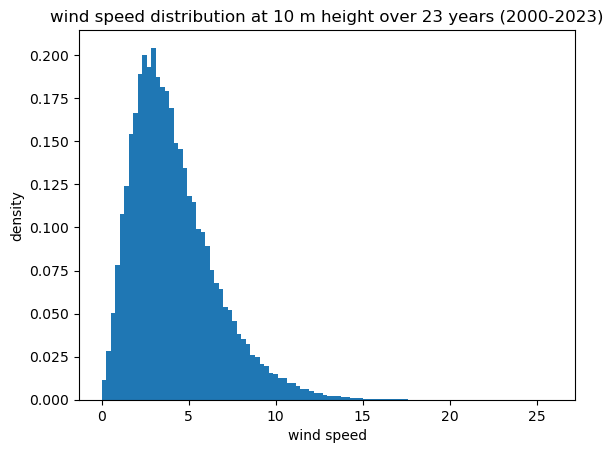

In [3]:
plt.hist(data['F10'],bins=100,density=True)
plt.xlabel("wind speed")
plt.ylabel("density")
plt.title("wind speed distribution at 10 m height over 23 years (2000-2023)")

# Extreme value analysis



In [2]:
import pyextremes as pe

Year
2001-07-01    18.680000
2002-07-01    20.350000
2003-07-01    25.920000
2004-07-01    22.559999
2005-07-01    18.430000
2006-07-01    16.020000
2007-07-01    22.559999
2008-07-01    17.459999
2009-07-01    19.340000
2010-07-01    16.100000
2011-07-01    17.530001
2012-07-01    19.139999
2013-07-01    18.540001
2014-07-01    20.740000
2015-07-01    19.299999
2016-07-01    20.129999
2017-07-01    19.980000
2018-07-01    23.100000
2019-07-01    18.600000
2020-07-01    20.410000
2021-07-01    16.435001
2022-07-01    15.291000
2023-07-01    17.679998
Name: F10, dtype: float32


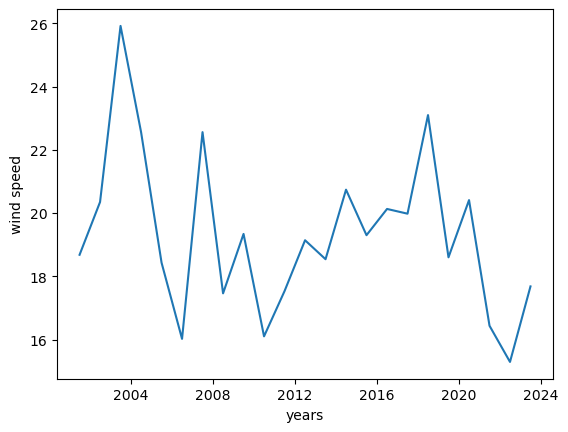

Text(0, 0.5, 'density')

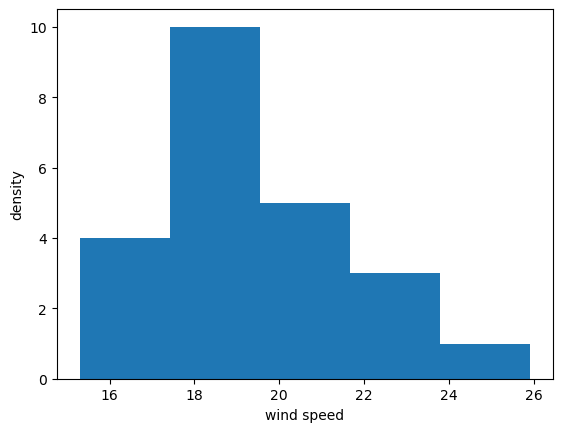

In [ ]:
yearly_max_wind_speed = data.groupby('Year')['F10'].max()[1:-1]
print(yearly_max_wind_speed)
plt.plot(yearly_max_wind_speed)
plt.xlabel("years")
plt.ylabel("wind speed")
plt.show()
plt.hist(yearly_max_wind_speed,bins=5)
plt.xlabel("wind speed")
plt.ylabel("density")

(<Figure size 768x480 with 1 Axes>, <Axes: xlabel='DateTime', ylabel='F10'>)

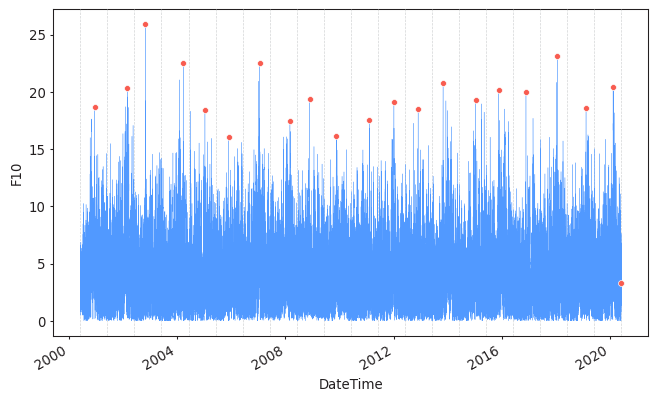

In [7]:
data_winter = data[~data['Year'].isin(['2000-07-01','2021-07-01','2022-07-01','2023-07-01','2024-07-01'])]
data_winter = data_winter['F10']
data_winter = data_winter[~data_winter.isna()]
model = pe.EVA(data_winter)
model.get_extremes(method="BM", block_size="365.2425D")
model.plot_extremes()


In [ ]:
model.fit_model()

In [ ]:
summary = model.get_summary(
    return_period=[ 50, 100, 250, 500, 1000,4000, 10000],
    alpha=0.95,
    n_samples=1000,
)
summary

,return value,lower ci,upper ci
return period,,,
50.0,25.443036,22.361120,27.685845
100.0,25.766486,22.502401,29.279965
250.0,26.043199,22.548083,32.074918
500.0,26.177932,22.554396,33.985810
1000.0,26.270593,22.557353,36.512495
4000.0,26.378244,22.559388,42.181233
10000.0,26.416018,22.559768,46.131566


(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='F10'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='F10', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

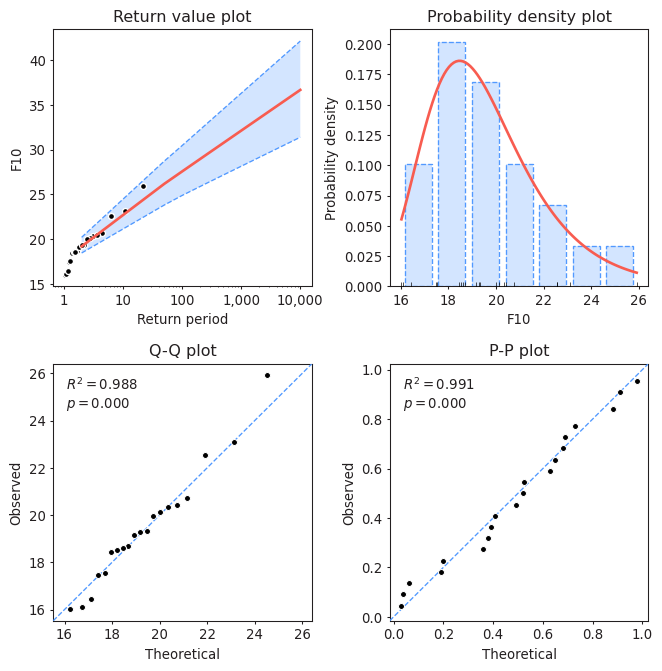

In [ ]:
model.plot_diagnostic(return_period=[2, 50, 100, 250, 500, 1000,4000, 10000],alpha=0.95)


Peak over threshold

DateTime
2000-06-01 00:00:00    False
2000-06-01 00:10:00    False
2000-06-01 00:20:00    False
2000-06-01 00:30:00    False
2000-06-01 00:40:00    False
                       ...  
2021-05-31 23:10:00     True
2021-05-31 23:20:00     True
2021-05-31 23:30:00     True
2021-05-31 23:40:00     True
2021-05-31 23:50:00     True
Name: F10, Length: 1087200, dtype: bool

(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='F10'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='F10', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

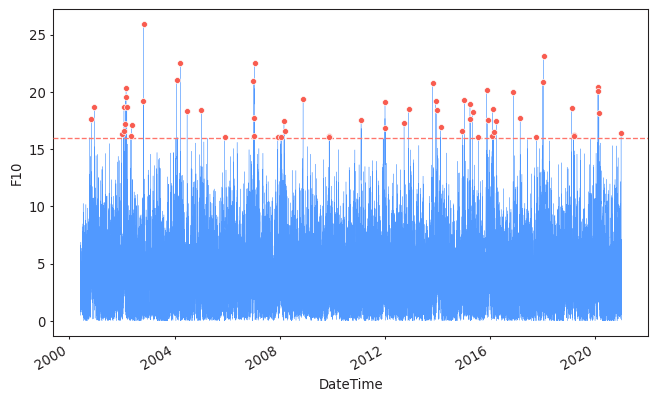

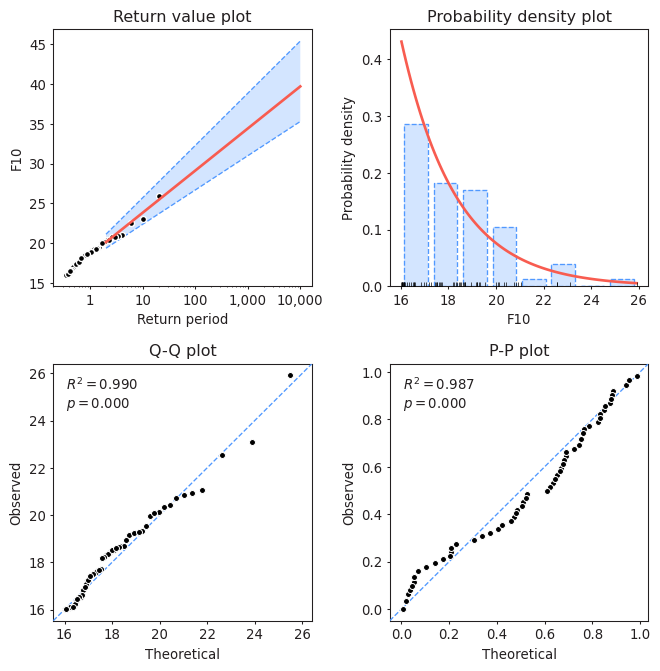

In [ ]:

modelPOT = pe.EVA(data_winter)
modelPOT.get_extremes(method="POT",threshold=16)
modelPOT.plot_extremes()
modelPOT.fit_model()
modelPOT.plot_diagnostic(plotting_position='ecdf',return_period=[2, 50, 100, 250, 500, 1000,4000, 10000],alpha=0.95)

# summary = modelPOT.get_summary(
#     return_period=[ 50, 100, 250, 500, 1000,4000, 10000],
#     alpha=0.95,
#     n_samples=1000,
# )
# summary

test de differents seuils

(<Axes: ylabel='Shape, $\\xi$'>,
 <Axes: ylabel='Modified scale, $\\sigma^*$'>,
 <Axes: ylabel='Return value'>,
 <Axes: xlabel='Threshold', ylabel='AIC Score'>)

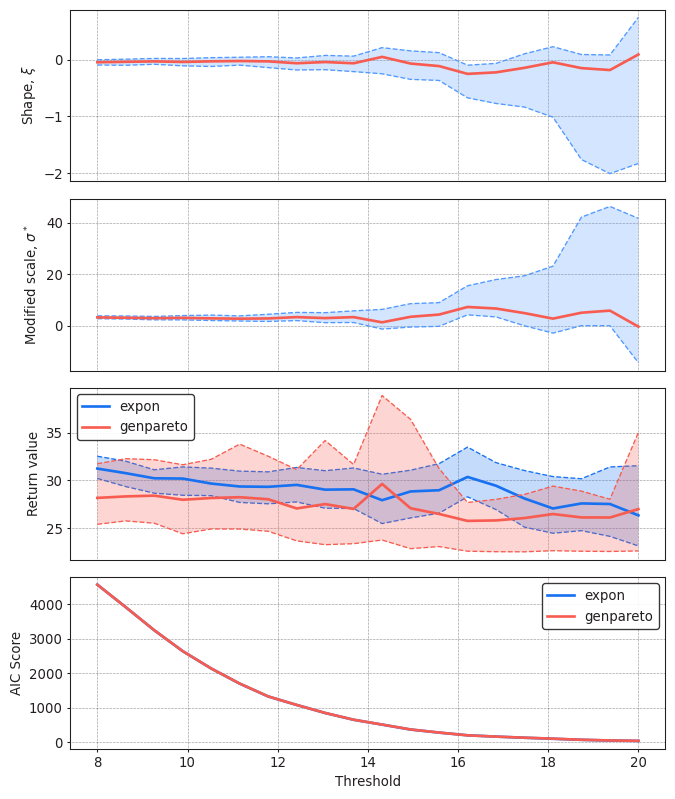

In [ ]:
pe.plot_threshold_stability(data_winter,
                            return_period=100,
                            thresholds=np.linspace(8, 20, 20),
                            alpha=0.95)

# henk paper
 

Try to plot: $log(h)$ function of $\bar{u}$ from Cabauw dataset. It should be a straight line. Gust should be with an offset of 14. Look at the shape parameter

c:\Users\alexa\anaconda3\Lib\site-packages\pyextremes\eva.py:131: RuntimeWarning: 13,200 Null values found in `data` - removing invalid entries
  warnings.warn(message=message, category=RuntimeWarning)
c:\Users\alexa\anaconda3\Lib\site-packages\pyextremes\eva.py:131: RuntimeWarning: 6,277 Null values found in `data` - removing invalid entries
  warnings.warn(message=message, category=RuntimeWarning)
c:\Users\alexa\anaconda3\Lib\site-packages\pyextremes\eva.py:131: RuntimeWarning: 5,824 Null values found in `data` - removing invalid entries
  warnings.warn(message=message, category=RuntimeWarning)
c:\Users\alexa\anaconda3\Lib\site-packages\pyextremes\eva.py:131: RuntimeWarning: 5,238 Null values found in `data` - removing invalid entries
  warnings.warn(message=message, category=RuntimeWarning)
c:\Users\alexa\anaconda3\Lib\site-packages\pyextremes\eva.py:131: RuntimeWarning: 5,879 Null values found in `data` - removing invalid entries
  warnings.warn(message=message, category=RuntimeWar

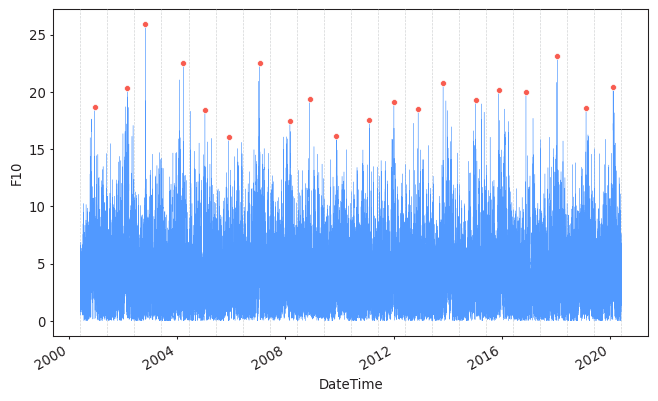

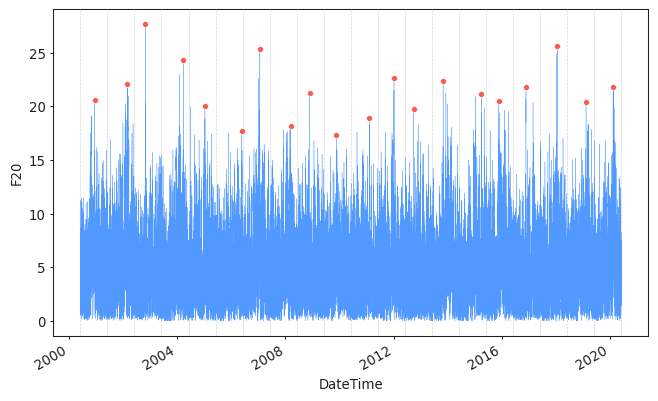

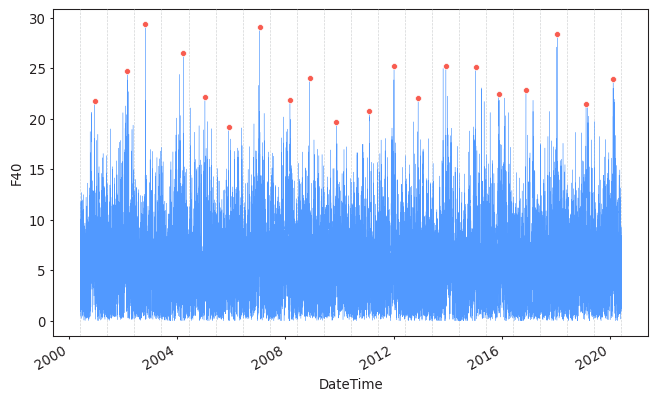

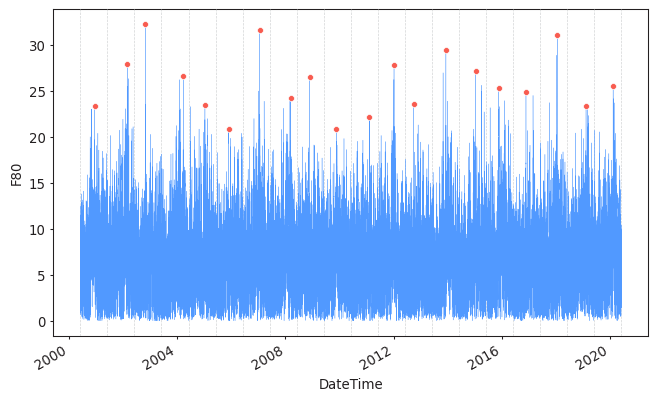

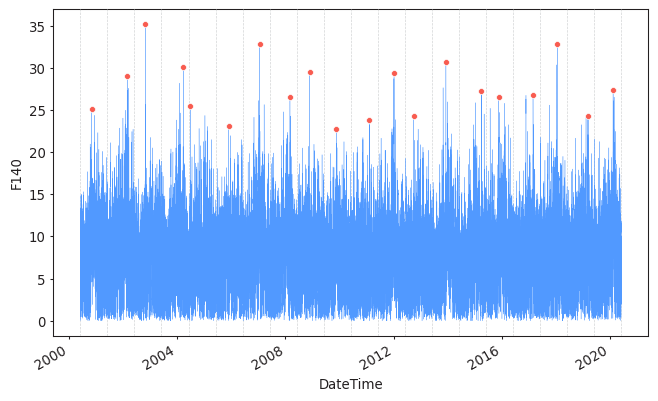

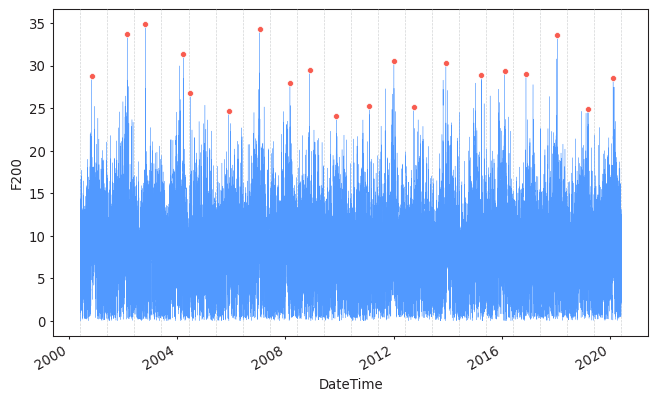

In [ ]:
data_winter = data[~data['Year'].isin(['2000-07-01','2021-07-01','2022-07-01','2023-07-01','2024-07-01'])]
heights = [10,20,40,80,140,200]
models = {}
for h in heights:
    models[h] = pe.EVA(data_winter[f'F{h}'])
    models[h].get_extremes(method="BM", block_size="365.25D")
    models[h].plot_extremes()
    models[h].fit_model()
    # models[h].plot_return_values(return_period=[2,10, 50, 100, 250, 500, 1000,4000, 10000],alpha=0.95)

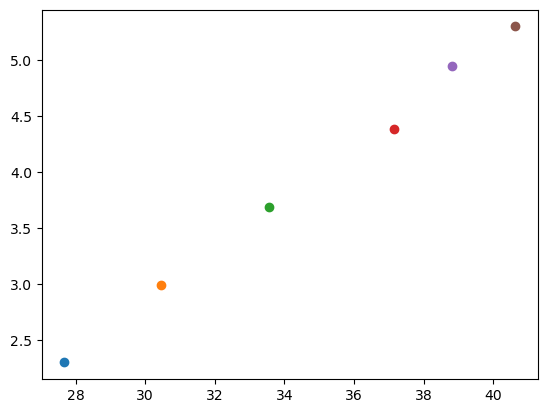

In [ ]:
rv = []
# u_t = lambda u,h: 0.41*u/np.log(h/0.03)
return_periods = 100
for h in heights:
    rv.append(models[h].get_summary(return_periods,alpha=0.95))
    plt.scatter(rv[-1]['return value'],np.log(h))
    # plt.scatter(u_t(rv[-1]['return value'],h),np.log(h))



c:\Users\alexa\anaconda3\Lib\site-packages\pyextremes\eva.py:131: RuntimeWarning: 13,200 Null values found in `data` - removing invalid entries
  warnings.warn(message=message, category=RuntimeWarning)
c:\Users\alexa\anaconda3\Lib\site-packages\pyextremes\eva.py:131: RuntimeWarning: 6,277 Null values found in `data` - removing invalid entries
  warnings.warn(message=message, category=RuntimeWarning)
c:\Users\alexa\anaconda3\Lib\site-packages\pyextremes\eva.py:131: RuntimeWarning: 5,824 Null values found in `data` - removing invalid entries
  warnings.warn(message=message, category=RuntimeWarning)
c:\Users\alexa\anaconda3\Lib\site-packages\pyextremes\eva.py:131: RuntimeWarning: 5,238 Null values found in `data` - removing invalid entries
  warnings.warn(message=message, category=RuntimeWarning)
c:\Users\alexa\anaconda3\Lib\site-packages\pyextremes\eva.py:131: RuntimeWarning: 5,879 Null values found in `data` - removing invalid entries
  warnings.warn(message=message, category=RuntimeWar

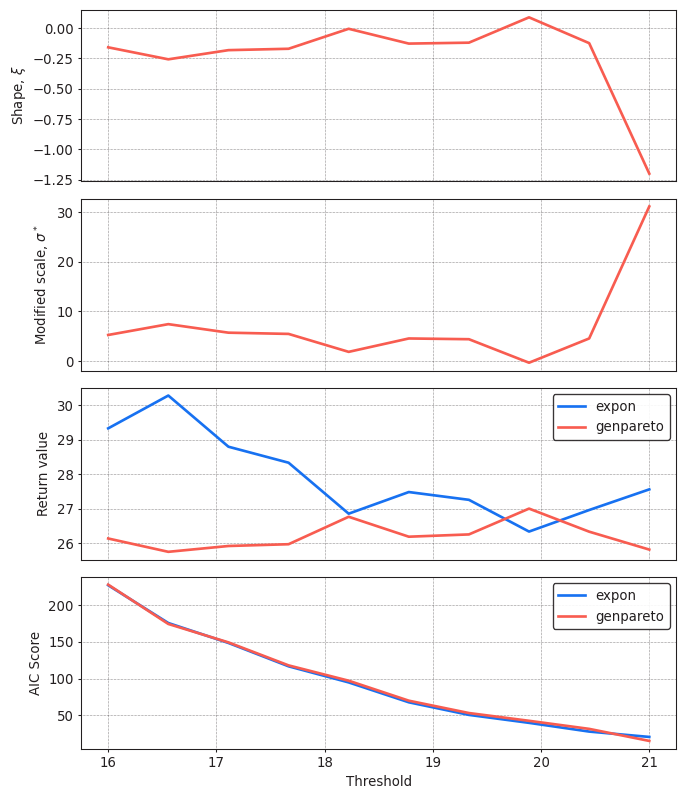

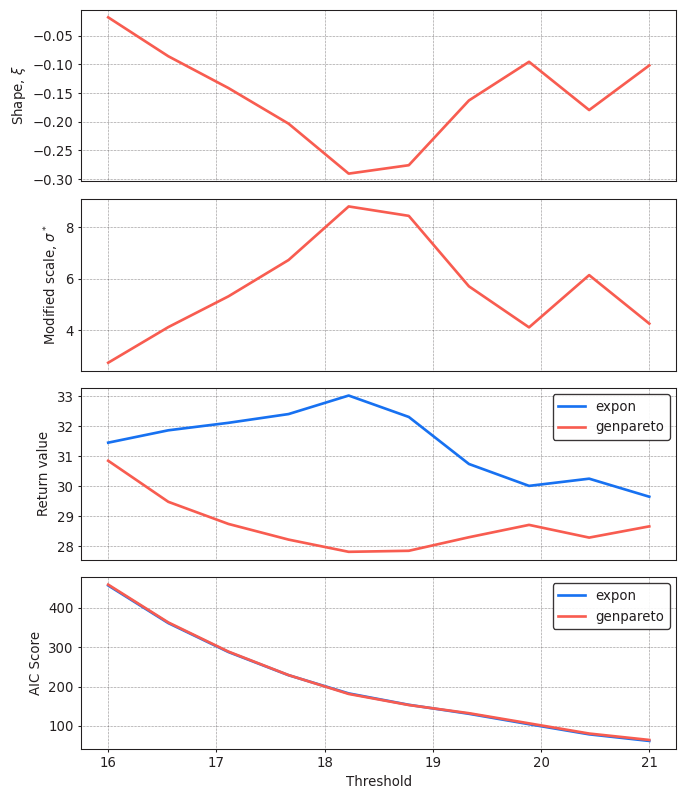

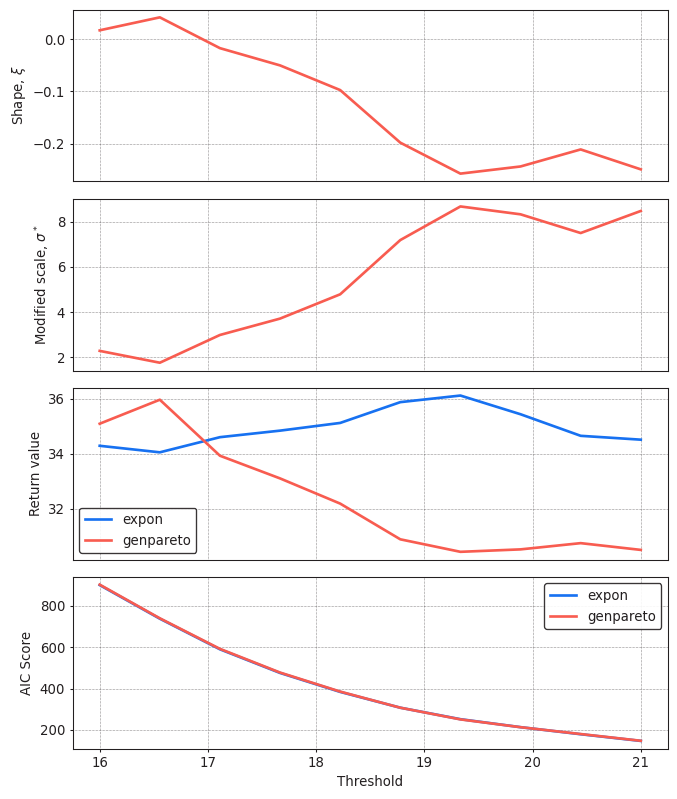

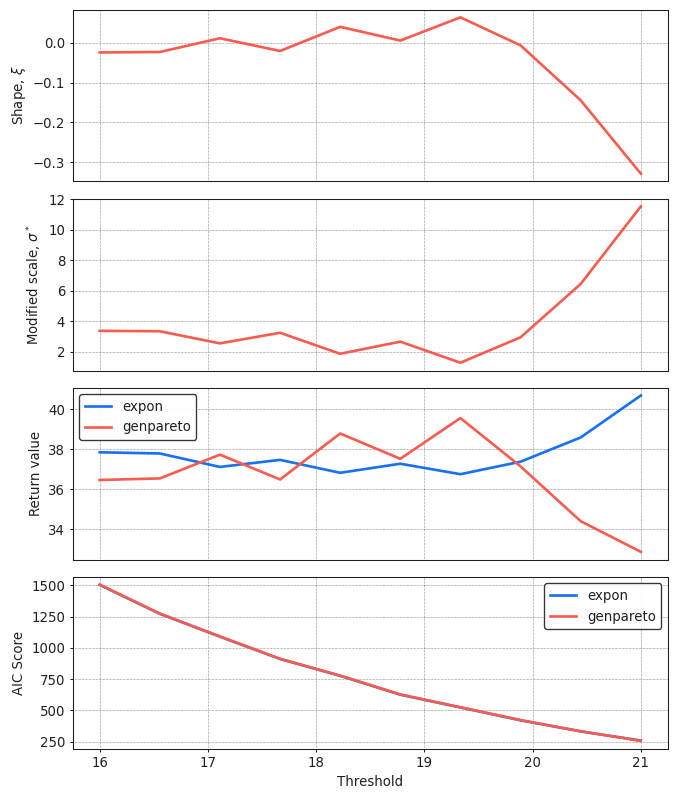

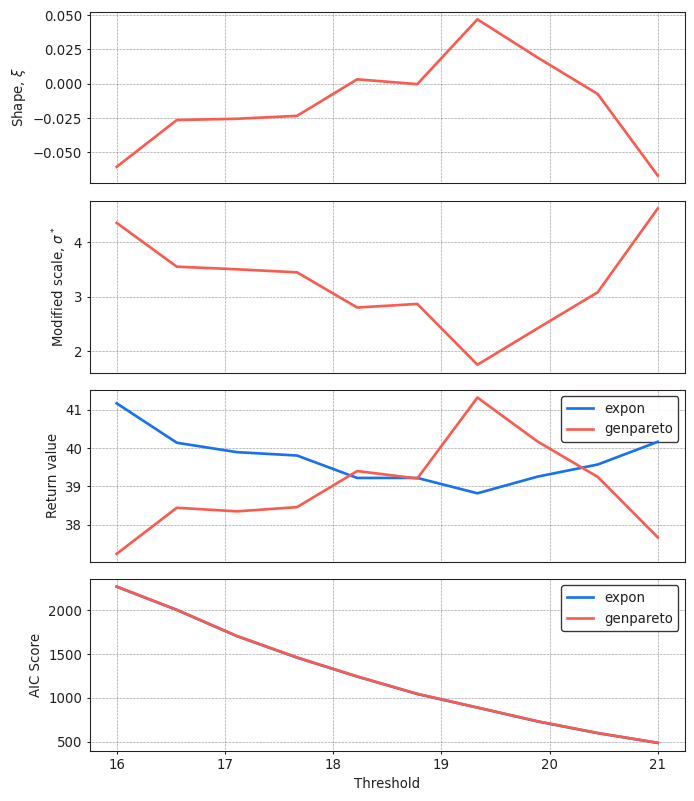

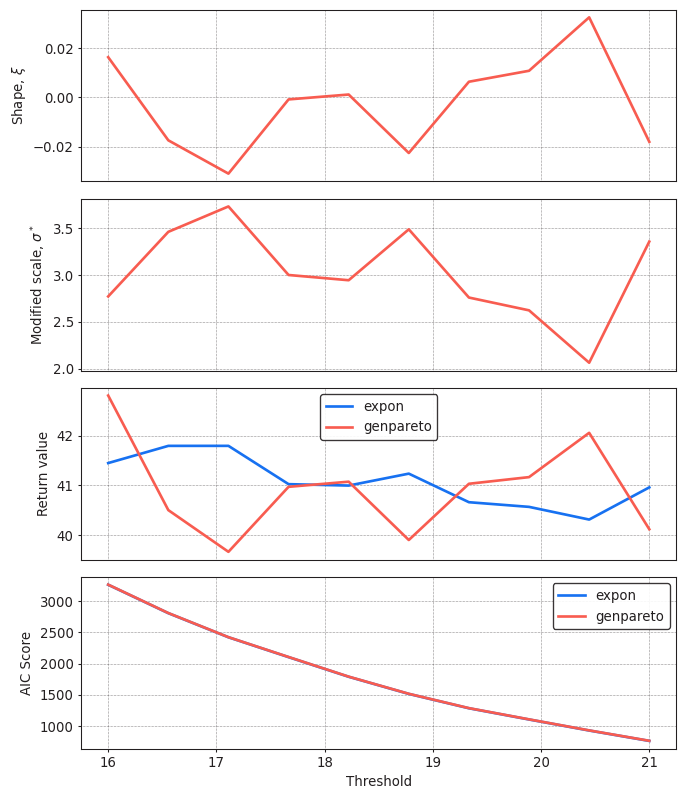

In [ ]:

for h in heights:
    pe.plot_threshold_stability(
        data_winter[f'F{h}'],
        return_period=return_periods,
        thresholds=np.linspace(16,21,10)
        )

# 3s Gust at 10 m

see henk's paper. Median gust value at 10 m is approximativly equal to 10min-mean wind speed at 140m. 

$G^{50\%}(10m) \simeq U(140m)$

# test

### height dependance


### Test PCA

In [ ]:

test_norm = (test-test.mean())/test.std()
pca = PCA(1)
test_pca = pca.fit_transform(test_norm)
test_pca = pd.Series(test_pca.T[0],data_model['DTG'])

plt.figure(1,figsize=(10,6))
# plt.subplot(121).plot(pca.explained_variance_ratio_)
# plt.subplot(122).scatter(test_pca[0],test_pca[1],s=5)

test_pca = test_pca[test_pca.index> datetime(1979,7,1)]
test_pca = test_pca[test_pca.index< datetime(2019,7,1)]

test_pca.tail()


import pyextremes as pe
# print(isinstance(test_pca, pd.Series))
eva = pe.EVA(test_pca)
eva.get_extremes('BM', block_size="365.25D")
# eva.plot_extremes()
eva.fit_model()
# eva.plot_diagnostic()

sum = eva.get_summary([50,100,1000,10000],alpha=0.95)

pca_inv = pca.inverse_transform(np.array([sum['return value']]).T)
pca_inv = pd.DataFrame(pca_inv,index=sum.index,columns=test.columns)


pd.DataFrame(pca_inv)*test.std() + test.mean()

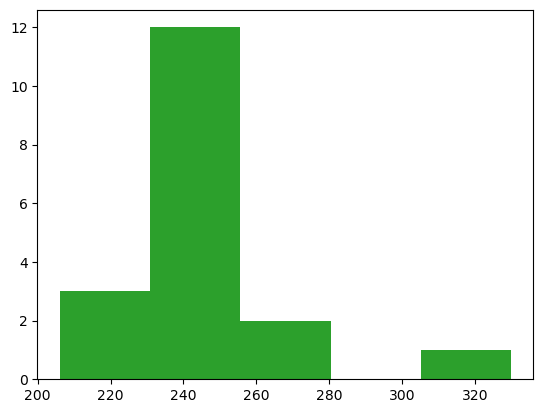

In [15]:
data_winter = data[~data['Year'].isin(['2000-07-01','2021-07-01','2022-07-01','2023-07-01','2024-07-01'])]
idx = data_winter.groupby('Year')['F10'].idxmax()[1:-1]

plt.hist(data_winter['D10'][idx],bins=5)
plt.show()